# Notes

In [ ]:
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html

# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *
from src.helper_pipeline import *

from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report

# Configuration

In [63]:
# CONGRATULATIONS, ready to go 🚀

# DATA PREPARATION
TITLE_WORDS_MIN = 4             # the minimum number of words in the title
TITLE_WORDS_MAX = 15            # the maximum number of words in the title
TEXT_COL = 'Title_Enhanced'   # the text column to be used for training
TARGET_COL = 'Product Name'     # the target column to be used for training
FILER_COL = 'Length'            # the filter column to be used for training
PRODUCT_SIZE_MAX_TRAIN = 6000   # the maximum number of samples for each product in training set to balance the data
PRODUCT_SIZE_MAX_TEST = None    # the maximum number of samples for each product in test set to balance the data
TOP_N_PRODUCTS = 25             # the top n products to be used for training, the rest will be lumped into 'Others'
PRODUCT_OTHERS = f'Other Products (not in Top {TOP_N_PRODUCTS})'  # the name of the 'Others' product

# TRAINING
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
CLASS_WEIGHT_POWER = 0.5          # the power of the class weight. 0.5 means square root, 1 means linear, 2 means square
CLASS_WEIGHT_FACTOR = -1         # the times of the largest class as the weight of the minor classes. set to 1 to disable class weight. set to -1 no cap

# BERT_MODEL_NAME = 'distilbert-base-uncased' # 6-layer, 768-hidden, 12-heads, 66M parameters. Trained on lower-cased English text.
BERT_MODEL_NAME = 'bert-base-uncased' # 12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.
MAX_EPOCH = 50
EARLY_STOP_PATIENCE = 5
BATCH_SIZE = 128
FRACTION = 1.0
# CONGRATULATIONS, ready to go 🚀

# Data Loading

df_train has 90197 records, memory usage: 6MB


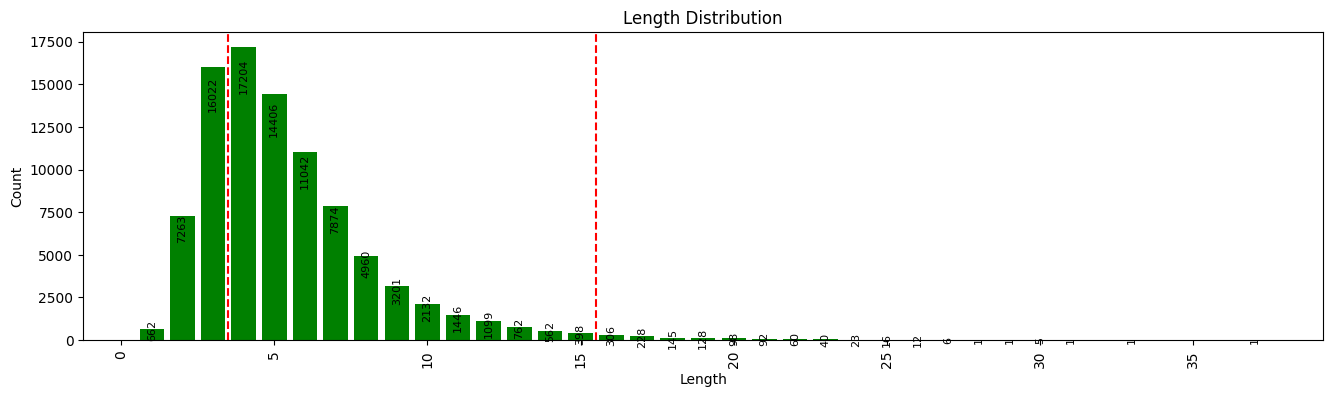

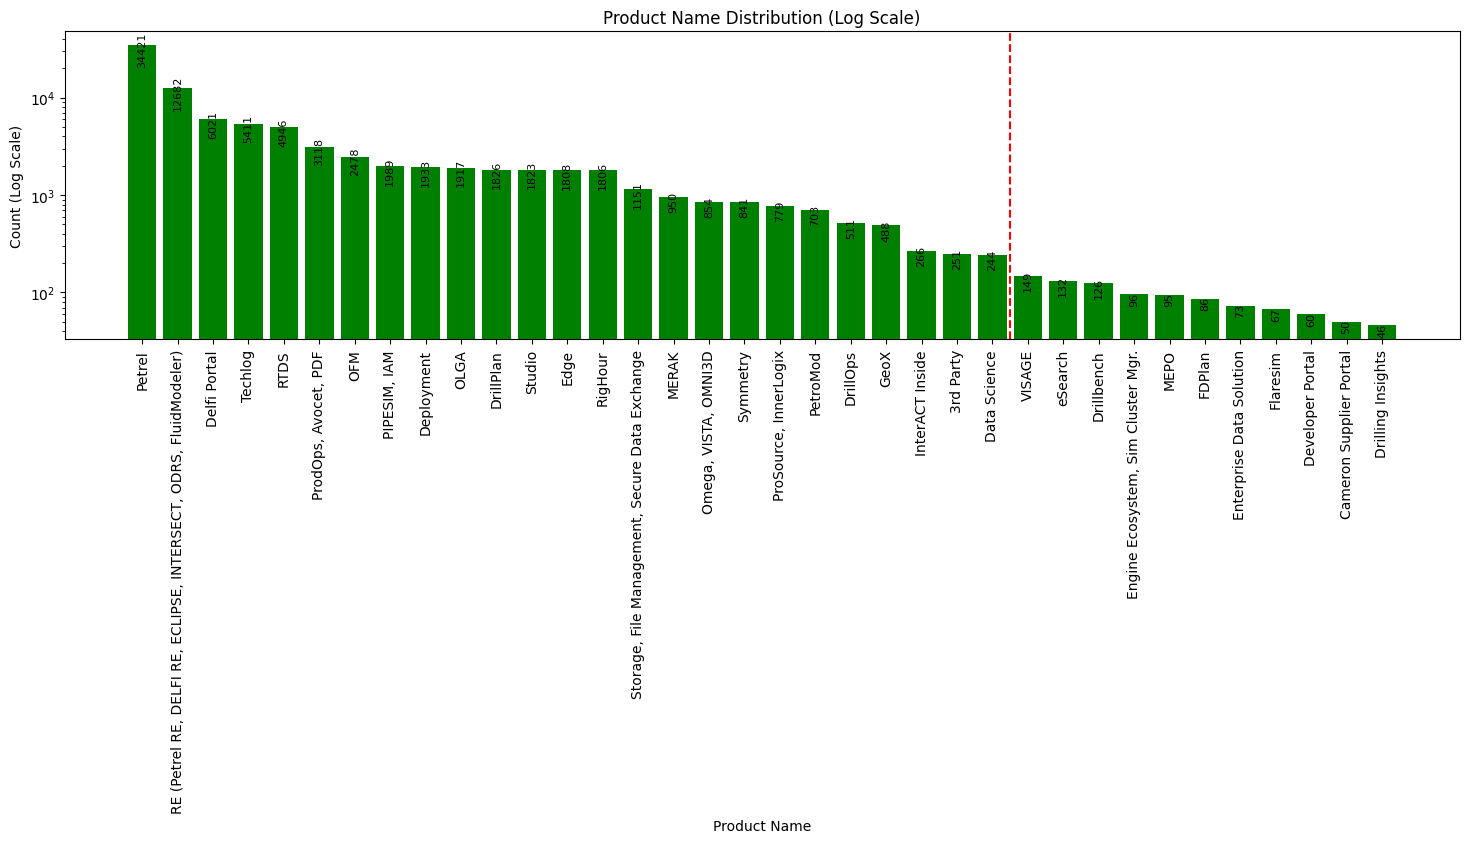

In [64]:
if 'df_train' not in locals():
    excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
    df_train = pd.read_excel(excel_file_train)
print(f'df_train has \033[94m{df_train.shape[0]}\033[0m records, memory usage: \033[94m{df_train.memory_usage().sum()//(1024*1024)}\033[0mMB')

hist_by_labels(df_train, FILER_COL, log=False, left=TITLE_WORDS_MIN-.5, right=TITLE_WORDS_MAX+.5)
hist_by_labels(df_train, 'Product Name', log=True, right=TOP_N_PRODUCTS-.5)
df_train.sample(10, random_state=42)

# Get the Product Name list of Top N products
def get_top_n_products(df, target_col, n):
    df_target = df[target_col].value_counts().to_frame().reset_index()
    df_target.columns = [target_col, 'count']
    df_target = df_target.sort_values(by='count', ascending=False)
    df_target = df_target.head(n)
    return df_target[target_col].tolist()

top_n_products = get_top_n_products(df_train, TARGET_COL, TOP_N_PRODUCTS)

# Data Processing

Define the data preparation pipeline

In [65]:
# create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
pipeline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(filter_name=FILER_COL, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL, product_name=PRODUCT_OTHERS)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

pipeline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(filter_name=FILER_COL, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL, product_name=PRODUCT_OTHERS)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

display(pipeline_data_prep_train)
display(pipeline_data_prep_test)

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(filter_name='Length', max_words=15,
                                   min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(product_name='Other Products (not in '
                                                    'Top 25)',
                                       target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Av...
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper',
                 SampleCapper(max_samples=6000, target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Enhanced'))])

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(filter_name='Length', max_words=15,
                                   min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(product_name='Other Products (not in '
                                                    'Top 25)',
                                       target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Av...
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper', SampleCapper(target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Enhanced'))])

Prepare data for the trainer

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the target labels
le = LabelEncoder()

# Train data
df_train_processed = pipeline_data_prep_train.fit_transform(df_train)
df_train_processed = df_train_processed.reset_index(drop=True)
df_train_processed = df_train_processed.rename(columns={TEXT_COL: 'text'})
df_train_processed['label'] = le.fit_transform(df_train_processed[TARGET_COL])

print(f'Train data has \033[94m{df_train_processed.shape[0]}\033[0m records, memory usage: \033[94m{df_train_processed.memory_usage().sum()//(1024*1024)}\033[0m MB')
display(df_train_processed.head())

Train data has 43617 records, memory usage: 3 MB


,Request ID,Title,Product Name,Title_Processed,Language,Length,Title_Translated,text,Tags,label
0,1699372,[Ext] Excel To PEEP loader license for 2023,MERAK,Excel To PEEP loader license for,en,4,Excel To PEEP loader license for,excel peep loader license,loader excel license peep,9
1,1294141,IWC Saudi <AAdy@slb.com> NAO BP Deepwater bit ...,RigHour,IWC Saudi NAO BP Deepwater bit size and Casing...,en,10,IWC Saudi NAO BP Deepwater bit size and Casing...,integrated well construction ( iwc ) nao deepw...,integrated casing nao construction bit deepwat...,21
2,1195512,Wells disappeared from wells Section.,"ProdOps, Avocet, PDF",Wells disappeared from wells Section.,en,4,Wells disappeared from wells Section.,wells disappeared wells section,well disappeared section,18
3,1959644,include extra data inside OFM,OFM,include extra data inside OFM,en,8,include extra data inside OFM,include extra data inside oil field management...,include management extra field ofm inside oil ...,10
4,623172,Bulk renaming Faults in Studio,Studio,Bulk renaming Faults in Studio,en,4,Bulk renaming Faults in Studio,bulk renaming faults studio,renaming fault studio bulk,23


# Hugging Face Transformer

In [60]:
# import Hugging Face transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate     # helper functions to used in trainer callback to compute accuracy, precision, recall, f1 during training

## Training

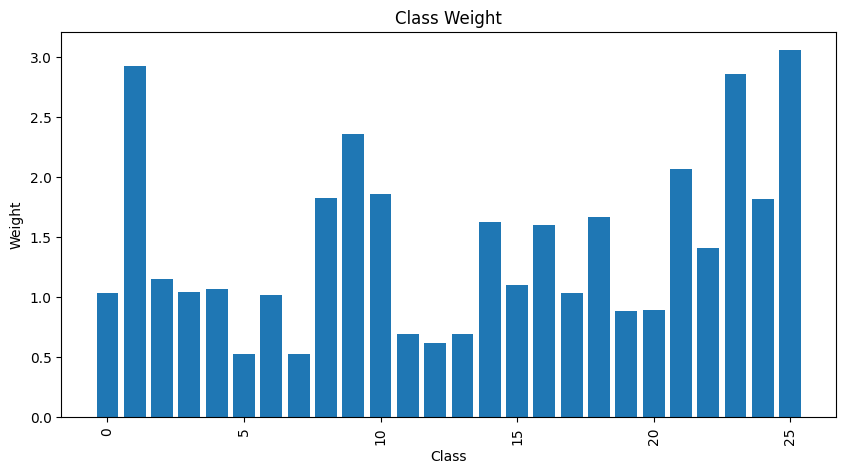

Map:   0%|          | 0/37074 [00:00<?, ? examples/s]

Map:   0%|          | 0/6543 [00:00<?, ? examples/s]

In [67]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
def tokenize(batch):
    return tokenizer(batch['text'], 
                    max_length=TITLE_WORDS_MAX,
                    padding='max_length', 
                    truncation=True)

# Split train data into train and eval
train_data = df_train_processed[['text', 'label']]
train_data, eval_data = train_test_split(train_data, test_size=0.15, stratify=train_data['label'], random_state=42)

# Sample the train and eval data to speed up the training
train_data = train_data.sample(frac=FRACTION, random_state=42).reset_index(drop=True)
eval_data = eval_data.sample(frac=FRACTION, random_state=42).reset_index(drop=True)

# Get the number of classes
n_classes = len(train_data.label.unique())

# Class weighting
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes=train_data.label.unique(), y=train_data.label)

# apply power to the class weight
class_weight = class_weight**CLASS_WEIGHT_POWER
# apply cap to the class weight
if CLASS_WEIGHT_FACTOR > 0:
    class_weight_max = class_weight.min()*CLASS_WEIGHT_FACTOR
    class_weight = {i: min(class_weight[i], class_weight_max) for i in range(len(class_weight))}

plot_class_weights({i: class_weight[i] for i in range(len(class_weight))})

hg_train_data = Dataset.from_pandas(train_data)
hg_eval_data = Dataset.from_pandas(eval_data)

# Tokenize the train and eval data
hg_train_data_tokenized = hg_train_data.map(tokenize)
hg_eval_data_tokenized = hg_eval_data.map(tokenize)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Configuration: Classify top 25 products; Text column: Title_Enhanced, Title words length: (4, 15); Records/product caped at 6000
100.0% Train_data has 37074 records; Eval_data has 6543 records;
Using bert-base-uncased model, Epoch=50, Early Stop Patience=5, Batch Size=128.


  0%|          | 0/14500 [00:00<?, ?it/s]

{'loss': 3.0566, 'learning_rate': 2.9e-06, 'epoch': 1.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 2.6185805797576904, 'eval_accuracy': 0.1901268531254776, 'eval_runtime': 8.7958, 'eval_samples_per_second': 743.879, 'eval_steps_per_second': 5.912, 'epoch': 1.0}
{'loss': 2.243, 'learning_rate': 4.971428571428572e-06, 'epoch': 2.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 1.7373955249786377, 'eval_accuracy': 0.5190279688216415, 'eval_runtime': 9.8496, 'eval_samples_per_second': 664.289, 'eval_steps_per_second': 5.279, 'epoch': 2.0}
{'loss': 1.5927, 'learning_rate': 4.867857142857143e-06, 'epoch': 3.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 1.3256564140319824, 'eval_accuracy': 0.6275408833868256, 'eval_runtime': 9.0366, 'eval_samples_per_second': 724.059, 'eval_steps_per_second': 5.754, 'epoch': 3.0}
{'loss': 1.286, 'learning_rate': 4.764285714285714e-06, 'epoch': 4.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 1.1347914934158325, 'eval_accuracy': 0.6691120281216567, 'eval_runtime': 9.0579, 'eval_samples_per_second': 722.355, 'eval_steps_per_second': 5.741, 'epoch': 4.0}
{'loss': 1.1112, 'learning_rate': 4.660714285714286e-06, 'epoch': 5.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 1.0411375761032104, 'eval_accuracy': 0.6923429619440623, 'eval_runtime': 8.6127, 'eval_samples_per_second': 759.693, 'eval_steps_per_second': 6.038, 'epoch': 5.0}
{'loss': 0.9945, 'learning_rate': 4.557142857142858e-06, 'epoch': 6.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.9599943161010742, 'eval_accuracy': 0.7111416781292985, 'eval_runtime': 9.8304, 'eval_samples_per_second': 665.587, 'eval_steps_per_second': 5.29, 'epoch': 6.0}
{'loss': 0.9093, 'learning_rate': 4.453571428571429e-06, 'epoch': 7.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.906952977180481, 'eval_accuracy': 0.7235213204951857, 'eval_runtime': 9.9529, 'eval_samples_per_second': 657.399, 'eval_steps_per_second': 5.225, 'epoch': 7.0}
{'loss': 0.8385, 'learning_rate': 4.350000000000001e-06, 'epoch': 8.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.8703994154930115, 'eval_accuracy': 0.7342197768607672, 'eval_runtime': 9.4027, 'eval_samples_per_second': 695.86, 'eval_steps_per_second': 5.53, 'epoch': 8.0}
{'loss': 0.7757, 'learning_rate': 4.246428571428572e-06, 'epoch': 9.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.840969443321228, 'eval_accuracy': 0.7467522543175913, 'eval_runtime': 8.6032, 'eval_samples_per_second': 760.535, 'eval_steps_per_second': 6.044, 'epoch': 9.0}
{'loss': 0.7267, 'learning_rate': 4.1428571428571435e-06, 'epoch': 10.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.8123121857643127, 'eval_accuracy': 0.7550053492281827, 'eval_runtime': 9.9021, 'eval_samples_per_second': 660.772, 'eval_steps_per_second': 5.251, 'epoch': 10.0}
{'loss': 0.6775, 'learning_rate': 4.0392857142857145e-06, 'epoch': 11.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.8021453022956848, 'eval_accuracy': 0.7618829283203423, 'eval_runtime': 9.0067, 'eval_samples_per_second': 726.456, 'eval_steps_per_second': 5.773, 'epoch': 11.0}
{'loss': 0.6422, 'learning_rate': 3.935714285714286e-06, 'epoch': 12.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7786552309989929, 'eval_accuracy': 0.76738499159407, 'eval_runtime': 8.9984, 'eval_samples_per_second': 727.131, 'eval_steps_per_second': 5.779, 'epoch': 12.0}
{'loss': 0.6049, 'learning_rate': 3.832142857142857e-06, 'epoch': 13.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7705667614936829, 'eval_accuracy': 0.7696775179581232, 'eval_runtime': 8.6768, 'eval_samples_per_second': 754.079, 'eval_steps_per_second': 5.993, 'epoch': 13.0}
{'loss': 0.5699, 'learning_rate': 3.7285714285714286e-06, 'epoch': 14.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.760200023651123, 'eval_accuracy': 0.7751795812318508, 'eval_runtime': 9.6882, 'eval_samples_per_second': 675.355, 'eval_steps_per_second': 5.367, 'epoch': 14.0}
{'loss': 0.5396, 'learning_rate': 3.625e-06, 'epoch': 15.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7578452825546265, 'eval_accuracy': 0.7780834479596516, 'eval_runtime': 10.0282, 'eval_samples_per_second': 652.46, 'eval_steps_per_second': 5.185, 'epoch': 15.0}
{'loss': 0.5187, 'learning_rate': 3.521428571428572e-06, 'epoch': 16.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.749178409576416, 'eval_accuracy': 0.7814458199602629, 'eval_runtime': 9.4996, 'eval_samples_per_second': 688.764, 'eval_steps_per_second': 5.474, 'epoch': 16.0}
{'loss': 0.4911, 'learning_rate': 3.4178571428571432e-06, 'epoch': 17.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7497518062591553, 'eval_accuracy': 0.7840440165061898, 'eval_runtime': 8.6001, 'eval_samples_per_second': 760.806, 'eval_steps_per_second': 6.046, 'epoch': 17.0}
{'loss': 0.4701, 'learning_rate': 3.314285714285714e-06, 'epoch': 18.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7486482262611389, 'eval_accuracy': 0.7881705639614855, 'eval_runtime': 8.88, 'eval_samples_per_second': 736.823, 'eval_steps_per_second': 5.856, 'epoch': 18.0}
{'loss': 0.4511, 'learning_rate': 3.210714285714286e-06, 'epoch': 19.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7537317872047424, 'eval_accuracy': 0.7903102552346019, 'eval_runtime': 8.9707, 'eval_samples_per_second': 729.372, 'eval_steps_per_second': 5.797, 'epoch': 19.0}
{'loss': 0.4319, 'learning_rate': 3.1071428571428574e-06, 'epoch': 20.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7498412132263184, 'eval_accuracy': 0.7909215955983494, 'eval_runtime': 9.334, 'eval_samples_per_second': 700.985, 'eval_steps_per_second': 5.571, 'epoch': 20.0}
{'loss': 0.415, 'learning_rate': 3.0035714285714292e-06, 'epoch': 21.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7558001279830933, 'eval_accuracy': 0.79382546232615, 'eval_runtime': 8.9513, 'eval_samples_per_second': 730.958, 'eval_steps_per_second': 5.809, 'epoch': 21.0}
{'loss': 0.3984, 'learning_rate': 2.9e-06, 'epoch': 22.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7476383447647095, 'eval_accuracy': 0.7961179886902032, 'eval_runtime': 9.5608, 'eval_samples_per_second': 684.36, 'eval_steps_per_second': 5.439, 'epoch': 22.0}
{'loss': 0.3825, 'learning_rate': 2.7964285714285716e-06, 'epoch': 23.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7591062784194946, 'eval_accuracy': 0.7921442763258444, 'eval_runtime': 9.0394, 'eval_samples_per_second': 723.835, 'eval_steps_per_second': 5.753, 'epoch': 23.0}
{'loss': 0.3698, 'learning_rate': 2.692857142857143e-06, 'epoch': 24.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7587902545928955, 'eval_accuracy': 0.7959651535992663, 'eval_runtime': 9.7295, 'eval_samples_per_second': 672.494, 'eval_steps_per_second': 5.345, 'epoch': 24.0}
{'loss': 0.357, 'learning_rate': 2.5892857142857148e-06, 'epoch': 25.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7696042060852051, 'eval_accuracy': 0.795200978144582, 'eval_runtime': 9.2379, 'eval_samples_per_second': 708.277, 'eval_steps_per_second': 5.629, 'epoch': 25.0}
{'loss': 0.3448, 'learning_rate': 2.485714285714286e-06, 'epoch': 26.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7710425853729248, 'eval_accuracy': 0.7962708237811401, 'eval_runtime': 8.9793, 'eval_samples_per_second': 728.678, 'eval_steps_per_second': 5.791, 'epoch': 26.0}
{'loss': 0.3353, 'learning_rate': 2.382142857142857e-06, 'epoch': 27.0}


  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7740012407302856, 'eval_accuracy': 0.7970349992358245, 'eval_runtime': 9.4062, 'eval_samples_per_second': 695.605, 'eval_steps_per_second': 5.528, 'epoch': 27.0}
{'train_runtime': 4664.1348, 'train_samples_per_second': 397.437, 'train_steps_per_second': 3.109, 'train_loss': 0.7975526159293806, 'epoch': 27.0}


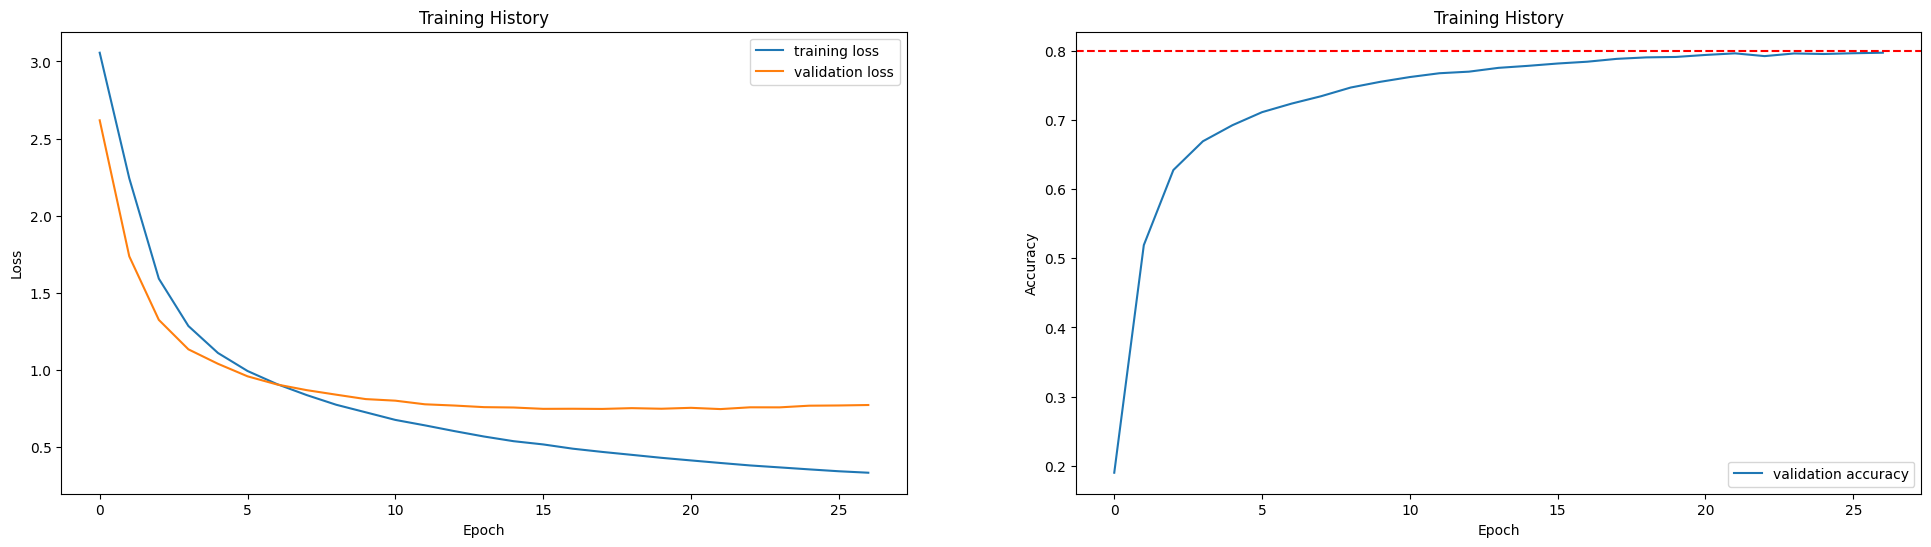

  0%|          | 0/52 [00:00<?, ?it/s]

{'eval_loss': 0.7476383447647095,
 'eval_accuracy': 0.7961179886902032,
 'eval_runtime': 8.9537,
 'eval_samples_per_second': 730.757,
 'eval_steps_per_second': 5.808,
 'epoch': 27.0}

In [68]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=n_classes)

# Define the training arguments
training_args = TrainingArguments(
    num_train_epochs=MAX_EPOCH,                 # total number of training epochs
    output_dir='./results',                     # output directory
    logging_dir='./logs',                       # directory for storing logs
    logging_strategy='epoch',                   # log every epoch
    logging_steps=100,                          # log every 100 steps
    warmup_steps=500,                           # number of warmup steps for learning rate scheduler
    per_device_train_batch_size=BATCH_SIZE,     # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,      # batch size for evaluation
    learning_rate=5e-6,                         # learning rate
    seed=42,                                    # seed for reproducibility
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

# Define the compute_metrics function to compute the accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = evaluate.load('accuracy')
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

import torch
from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weight), dtype=torch.float32).to(model.device))
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Create the Trainer instance to train the model
trainer = CustomTrainer(
    model=model,                            # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=hg_train_data_tokenized,  # training dataset
    eval_dataset=hg_eval_data_tokenized,    # evaluation dataset
    compute_metrics=compute_metrics,        # the callback that computes metrics of interest
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOP_PATIENCE)])


print()
print(f'Configuration: Classify top \033[94m{TOP_N_PRODUCTS}\033[0m products; Text column: \033[94m{TEXT_COL}\033[0m, Title words length: (\033[94m{TITLE_WORDS_MIN}\033[0m, \033[94m{TITLE_WORDS_MAX}\033[0m); Records/product caped at \033[94m{PRODUCT_SIZE_MAX_TRAIN}\033[0m')
print(f'\033[94m{FRACTION*100:.1f}%\033[0m Train_data has \033[94m{train_data.shape[0]}\033[0m records; Eval_data has \033[94m{eval_data.shape[0]}\033[0m records;')
print(f'Using \033[94m{BERT_MODEL}\033[0m model, Epoch=\033[94m{MAX_EPOCH}\033[0m, Early Stop Patience=\033[94m{EARLY_STOP_PATIENCE}\033[0m, Batch Size=\033[94m{BATCH_SIZE}\033[0m.')

trainer.train()

# Plot the training history and perform evaluation on the eval dataset
plot_transformer_training_history(trainer)
trainer.evaluate()

In [69]:
# Save the model
trainer.save_model(f'{MODEL_FOLDER_PATH}/model_{BERT_MODEL_NAME}_{TOP_N_PRODUCTS}_{TITLE_WORDS_MIN}_{TITLE_WORDS_MAX}_{PRODUCT_SIZE_MAX_TRAIN}_{FRACTION}.ckpt')
# save the tokenizer
tokenizer.save_pretrained(f'{MODEL_FOLDER_PATH}/model_{BERT_MODEL_NAME}_{TOP_N_PRODUCTS}_{TITLE_WORDS_MIN}_{TITLE_WORDS_MAX}_{PRODUCT_SIZE_MAX_TRAIN}_{FRACTION}')


('../models/model_bert-base-uncased_25_4_15_6000_1.0/tokenizer_config.json',
 '../models/model_bert-base-uncased_25_4_15_6000_1.0/special_tokens_map.json',
 '../models/model_bert-base-uncased_25_4_15_6000_1.0/vocab.txt',
 '../models/model_bert-base-uncased_25_4_15_6000_1.0/added_tokens.json',
 '../models/model_bert-base-uncased_25_4_15_6000_1.0/tokenizer.json')

## Evaluate on test data

,Request ID,Title,Product Name,Title_Processed,Language,Length,Title_Translated,text,Tags,label
0,871225,Property not showing general discrete template...,Petrel,Property not showing general discrete template...,en,6,Property not showing general discrete template...,property showing general discrete template option,template property general discrete option showing,15
1,2568681,PetroMod: how to define calibration points tha...,PetroMod,PetroMod how to define calibration points that...,en,8,PetroMod how to define calibration points that...,petromod define calibration points want includ...,include risk model calibration point define wa...,16
2,1585475,PD#1840186 | 1-1PRD91R | DELFI- Solutions & Se...,Delfi Portal,DELFI Solutions & Services Support TGX issue c...,en,6,DELFI Solutions & Services Support TGX issue c...,delfi solutions services tgx certificate expired,tgx delfi solution certificate expired service,2
3,1260582,Petrel: 断层上下盘拆分问题,Petrel,Petrel 断层上下盘拆分问题,zh,6,The problem of separation of the upper and low...,separation upper lower walls petrel fault,petrel separation lower wall upper fault,15
4,582779,How to change the crs of a realized file,Petrel,How to change the crs of realized file,en,7,How to change the crs of realized file,change coordinate reference system ( crs ) rea...,realized file coordinate change cr reference s...,15


,text,label
0,property showing general discrete template option,15
1,petromod define calibration points want includ...,16
2,delfi solutions services tgx certificate expired,2
3,separation upper lower walls petrel fault,15
4,change coordinate reference system ( crs ) rea...,15


Test data has 7245 records.


Map:   0%|          | 0/7245 [00:00<?, ? examples/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Accuracy: 0.7837
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.000     0.000     0.000        20
                                                    Data Science      0.410     0.696     0.516        23
                                                    Delfi Portal      0.570     0.703     0.629       471
                                                      Deployment      0.587     0.613     0.600       181
                                                        DrillOps      0.727     0.558     0.632        43
                                                       DrillPlan      0.704     0.610     0.654       164
                                                            Edge      0.973     0.973     0.973       184
                                                            GeoX      0.857     0.800     0.828        30
                            

/Users/haitao/.pyenv/versions/3.11.6/envs/HF/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.11.6/envs/HF/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.11.6/envs/HF/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

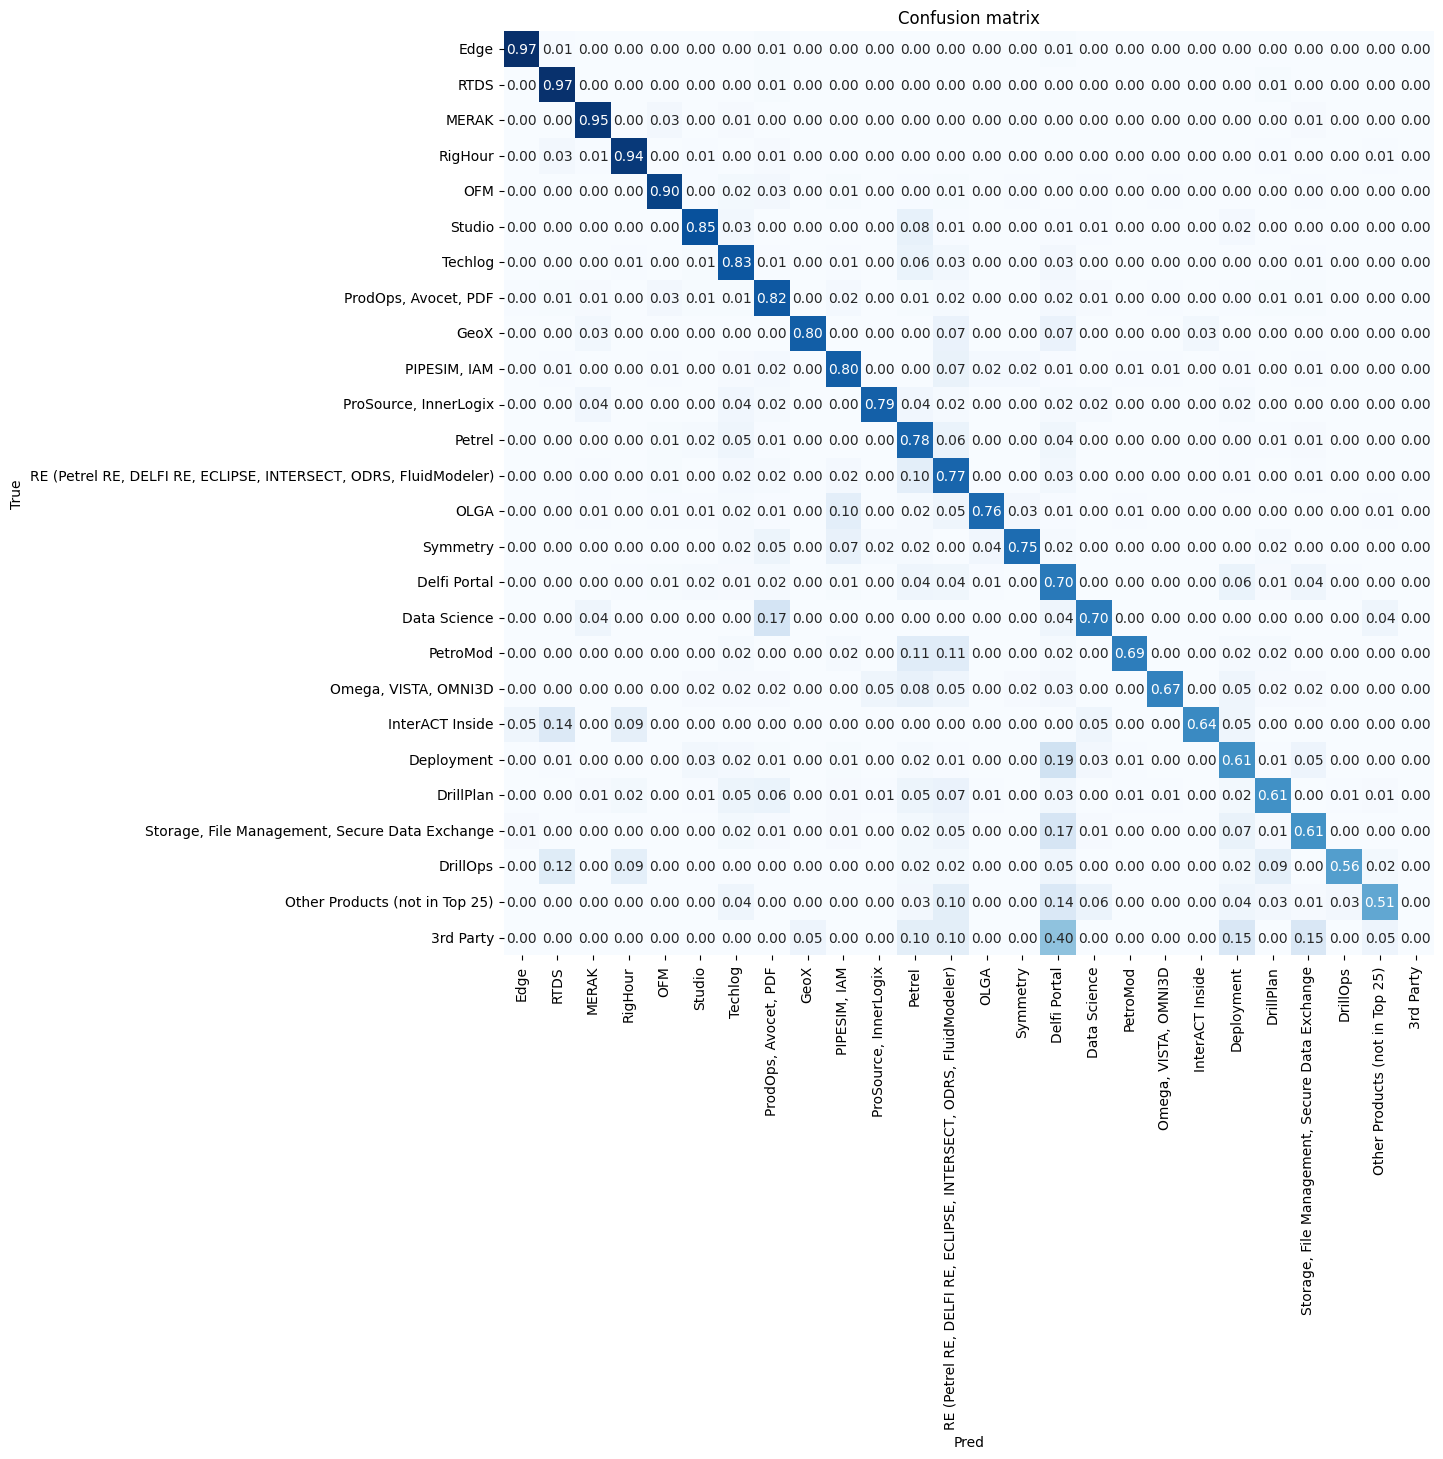

In [70]:
# Load test data
if 'df_test' not in locals():
    excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
    df_test = pd.read_excel(excel_file_test)

df_test_processed = pipeline_data_prep_test.fit_transform(df_test)
df_test_processed = df_test_processed.reset_index(drop=True)
df_test_processed = df_test_processed.rename(columns={TEXT_COL: 'text'})
df_test_processed['label'] = le.transform(df_test_processed[TARGET_COL])
display(df_test_processed.head())

# evaluate on test data
test_data = df_test_processed[['text', 'label']]
display(test_data.head())
print(f'Test data has \033[94m{test_data.shape[0]}\033[0m records.')

hg_test_data = Dataset.from_pandas(test_data)
hg_test_data_tokenized = hg_test_data.map(tokenize)

y_actual = hg_test_data_tokenized['label']
y_pred = trainer.predict(hg_test_data_tokenized)
y_pred = np.argmax(y_pred.predictions, axis=-1)

accuracy = accuracy_score(y_actual, y_pred)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_actual, y_pred, digits=3, target_names=le.classes_)
print(report)

y_actual_decoded = le.inverse_transform(y_actual)
y_pred_decoded = le.inverse_transform(y_pred)
plot_confusion_matrix(y_actual_decoded, y_pred_decoded)

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]

# Tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

In [ ]:
BATCH_SIZE = 32
NUM_TRAIN_SAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train

# encode the target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
NUM_CLASSES = len(df_train['Product Name'].unique())

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=NUM_CLASSES)

classifier.summary()

In [ ]:
# Compile the model
classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    metrics=['accuracy'])

# Fit the model.
history = classifier.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred_tf = classifier.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

# Decode the predictions
y_pred_tf = label_encoder.inverse_transform(y_pred_tf)

# Evaluate the model on the test data

accuracy = accuracy_score(y_test, y_pred_tf)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_tf, digits=3))

plot_confusion_matrix(y_test, y_pred_tf, title='Confusion matrix')